In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
from astropy.io import fits
from astropy.modeling import models, fitting
from multiprocessing import Pool, cpu_count
from sklearn.metrics import mean_squared_error
from scipy import stats
from numba import jit
from graph_tool.all import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse, Circle


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Lettura FITS

In [3]:
# Open the FITS file of F606w and F818w
fits_f606 = fits.open('../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f606w_v1_drz.fits')
fits_f814 = fits.open('../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f814w_v1_drz.fits')

# Data is stored as a 2-D numpy array
image_f606 = fits_f606[0].data
image_f814 = fits_f814[0].data

# info about F606w fits file
print(fits_f606.info())

# info about F814w fits file
print(fits_f814.info())

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   
None
Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f814w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7595   (10065, 10395)   float32   
None


Read stars dataset and filter out all negative values for the intensity.

In [4]:
names = ['ID', 'Xcor', 'Ycor', 'F606', 'eF606', 'F814', 'eF814', 'chi', 'sharp']
original = pd.read_csv('../Data/'+"Catalog/hlsp_deep47tuc_hst_acs_47tuc_f606w-f814w_v1_catalog.txt", 
                       names=names, delim_whitespace=True, skiprows=1)
data = original.copy()
#data = data[(data.sharp != 0) & (data.chi != 0)].reset_index(drop=True)

image = np.copy(image_f606)
image[image < 0] = 0

(array([8931., 8672., 8487., 8412., 8040., 8148., 7990., 7730., 7563.,
        7650.]),
 array([900.00006, 909.99994, 919.9999 , 929.99976, 939.99963, 949.9995 ,
        959.99945, 969.9993 , 979.9992 , 989.99915, 999.999  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

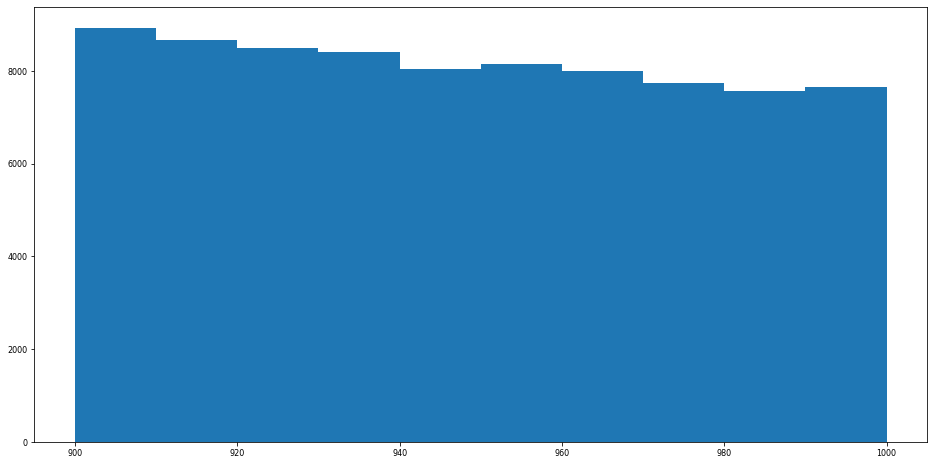

In [5]:
plt.hist(image[(image > 900) & (image < 1000)].ravel())

Find all image points where intensity values are in choosen range.

In [6]:
def find_coord(inf_int, sup_int, image=image):
    idys, idxs = np.where((image > inf_int) & (image < sup_int))
    ids = np.array((idxs, idys)).T
    return ids.astype(np.float64)

cor = data[['Xcor', 'Ycor']].to_numpy()

In [7]:
%%time


ids = find_coord(950, 1000)
ids.shape

CPU times: user 375 ms, sys: 188 ms, total: 562 ms
Wall time: 569 ms


(39081, 2)

Create a geometric graph where all the coordinates found before are vertices. Edges are assigned between all vertices at distance less than dist.

In [8]:
%%time

bb = 15.
dist = np.sqrt(2)*bb
g, pos = geometric_graph(ids, dist)
g.vp['pos'] = pos

g

CPU times: user 1 s, sys: 46.9 ms, total: 1.05 s
Wall time: 169 ms


<Graph object, undirected, with 39081 vertices and 223414 edges, 1 internal vertex property, at 0x7fde5f9d8b70>

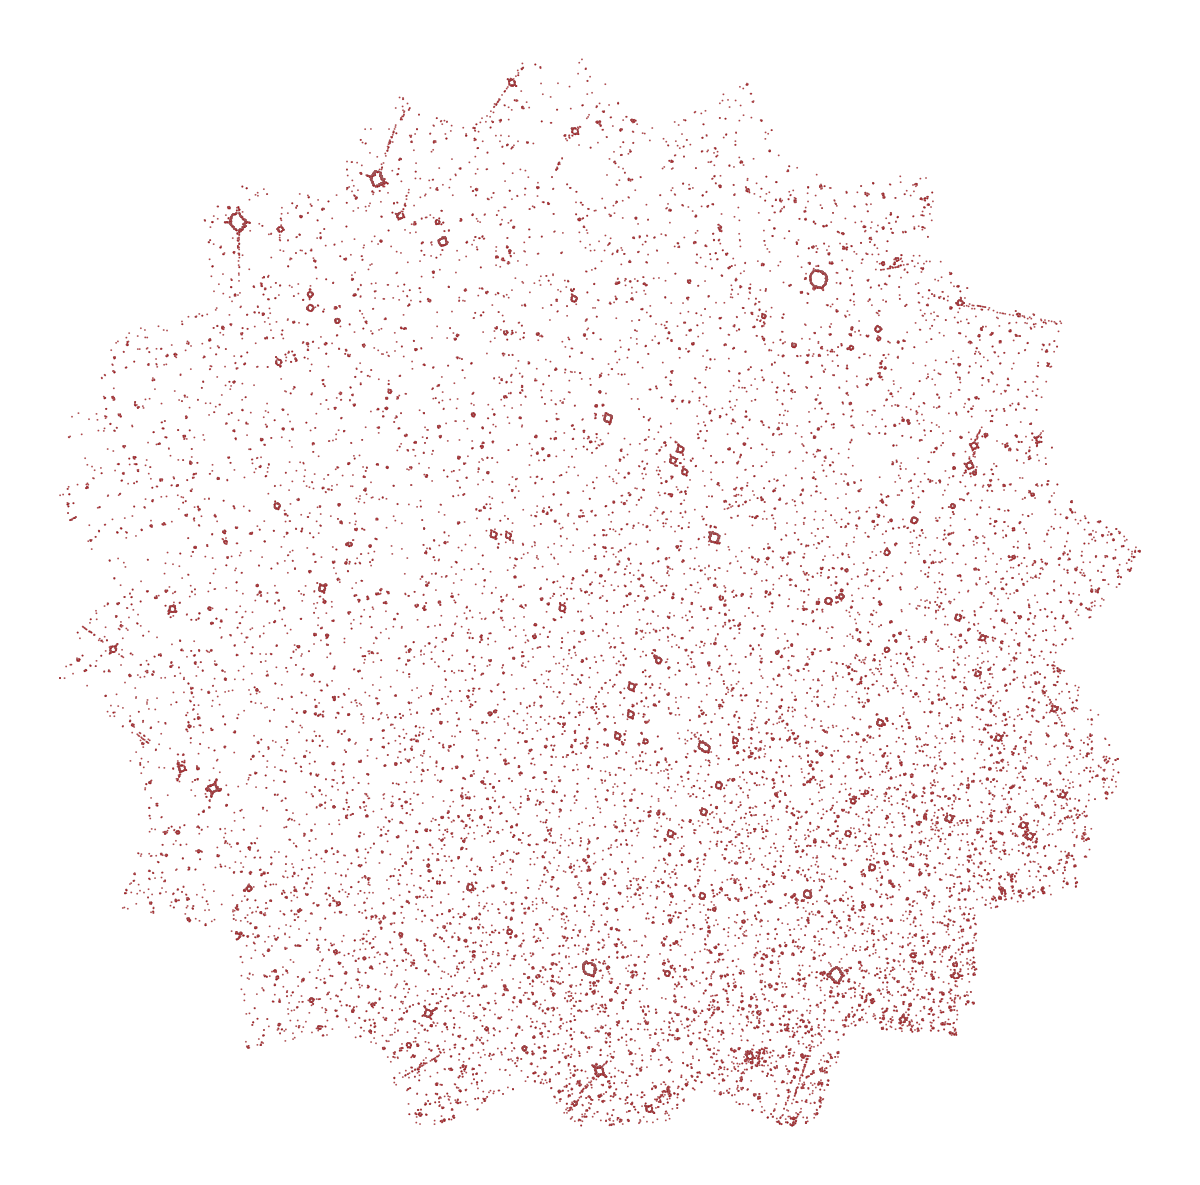

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fde5f9d8b70, at 0x7fde5f9d8dd8>

In [9]:
graph_draw(g, g.vp.pos)

In [10]:
%%time

# Filter out all vertices with at least 1 edge.
gv = GraphView(g, vfilt=g.degree_property_map("out").a==0)
gv

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.97 ms


<GraphView object, undirected, with 4017 vertices and 0 edges, 1 internal vertex property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fde5f9f56a0, at 0x7fde5f9f5cc0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fde5f9f56a0, at 0x7fde5f9f5c18>, False), at 0x7fde5f9f56a0>

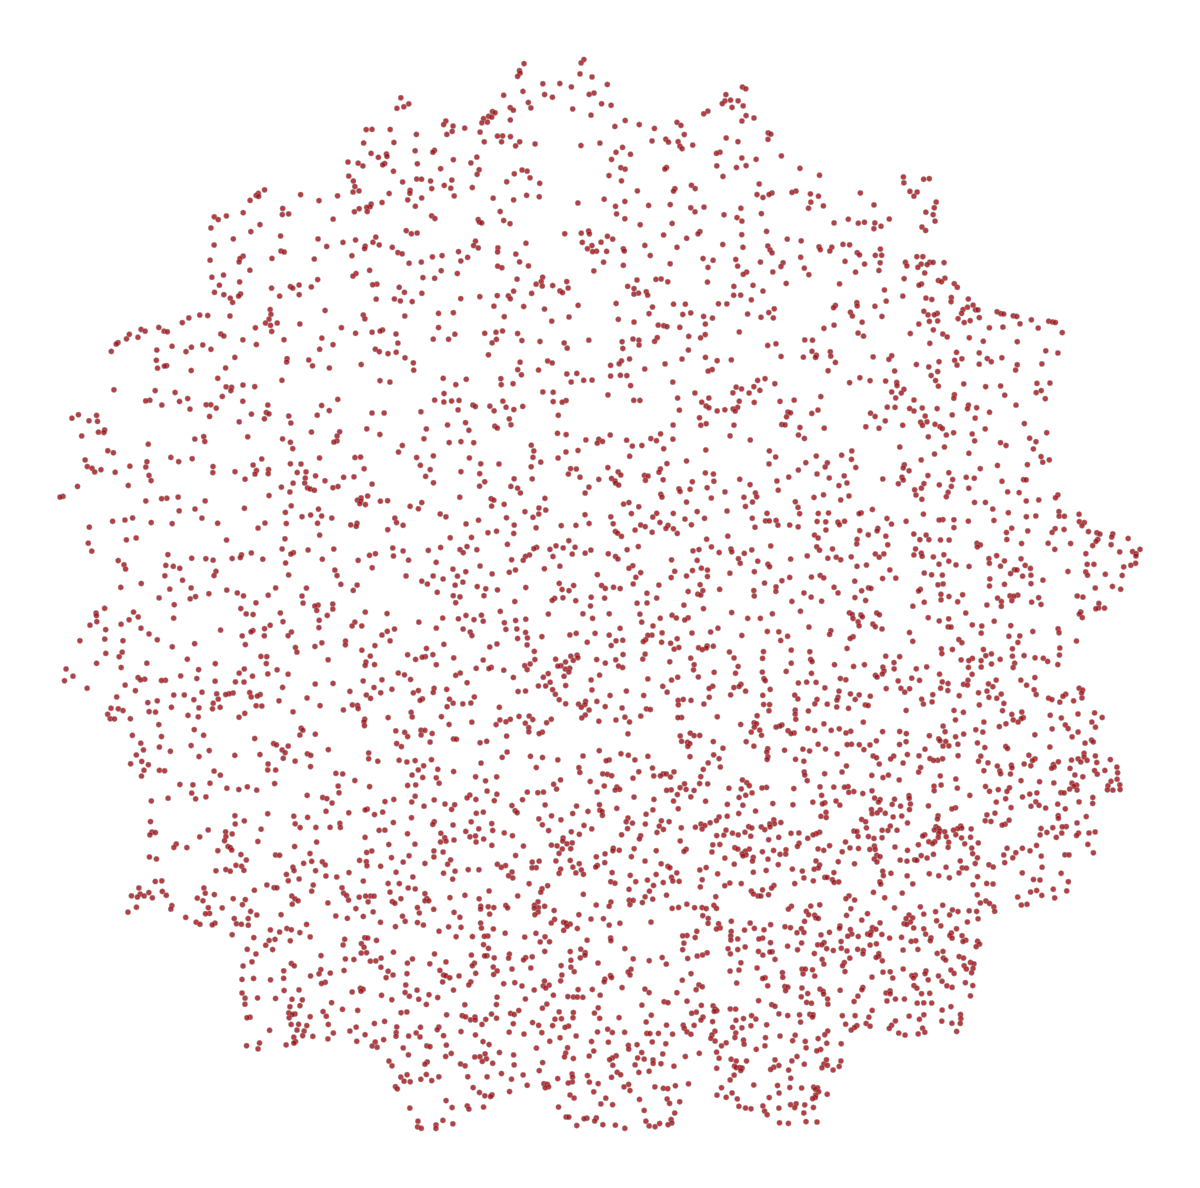

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fde5f9f56a0, at 0x7fde5f9f5940>

In [11]:
graph_draw(gv, gv.vp.pos)

In [12]:
ids_filt = gv.vp.pos.get_2d_array([0, 1]).T

del g, gv

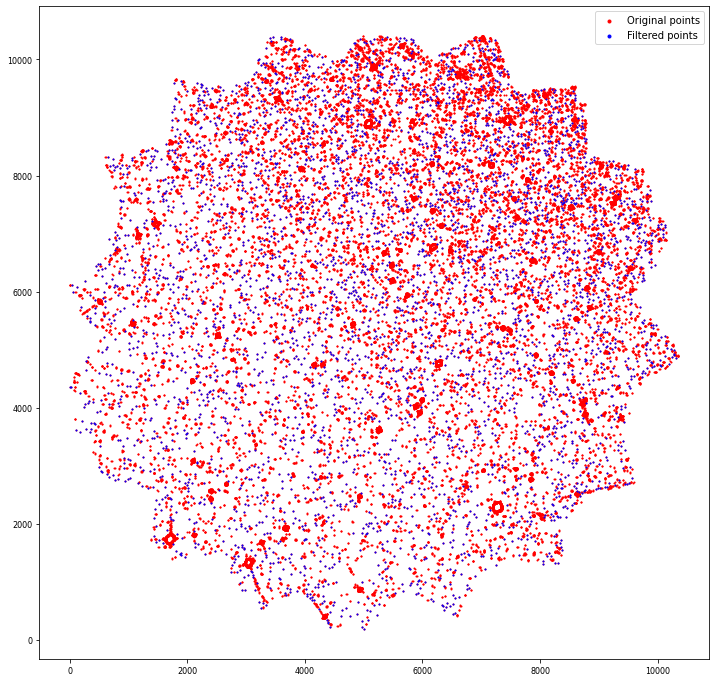

In [13]:
plt.figure(figsize=(12,12))
plt.scatter(ids[:,0], ids[:,1], s=1, c='r', label='Original points')
plt.scatter(ids_filt[:,0], ids_filt[:,1], s=1, c='b', label='Filtered points')
plt.legend(markerscale=3)
#plt.xlim(0, 2000)
#plt.ylim(1250, 2000)

In [14]:
@jit(nopython=True)
def find_IDs(cord, ids, Npixel):
    IDs = []
    n = len(ids)
    for i in range(n):
        tmp = (cord[:,0] - ids[i,0]) ** 2 + (cord[:,1] - ids[i,1]) ** 2 <= Npixel ** 2
        boh = np.sum(tmp)
        if boh:
            for j in cord[tmp, -1]:
                IDs.append(j)
    return IDs

In [15]:
cor = data[['Xcor', 'Ycor', 'ID']].to_numpy()
IDs = find_IDs(cor, ids_filt, 2)
len(IDs)

1182

In [16]:
def goodness_of_fit(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)

    return r2

# Fne Fit con pixel max intensità al centro

In [17]:
def Fit(id, df=data, img=image, bb=15, I_inf=100, I_sup=10000, npix=2):
    """
    Parameters
    ----------
    id     : integer
           star id
    df     : dataframe
           dataset containing all stars
    img    : 2D array-like
           data from fits file
    I_inf  : float
           lower bound for pixels intensity values 
    I_sup  : float
           upper bound for pixel intensity values
    npix   : integer
           distance [pixel] tollerance between data and image stars coordinates   
    Returns
    -------
    array-like
    star ID, fit init paramteres, best fit parameters and rms
    """   
    xc, yc = df.loc[df.ID == id, ['Xcor', 'Ycor']].to_numpy()[0]
    box = img[int(yc)-bb:int(yc)+bb, int(xc)-bb:int(xc)+bb]

    A_init = np.max(box)
    x_init = xc - bb + np.where(box == A_init)[1][0]
    y_init = yc - bb + np.where(box == A_init)[0][0] 

    if (np.int32([xc, yc]) != np.int32([x_init, y_init])).all():
        box = img[int(y_init) - bb: int(y_init) + bb, int(x_init) - bb: int(x_init) + bb]
        tmp_x, tmp_y = int(x_init), int(y_init)
    else:
        tmp_x, tmp_y = xc, yc
       
    X = np.arange(0, box.shape[1])
    Y = np.arange(0, box.shape[0])
    box = box / A_init
    box = box - np.min(box)
    yp, xp = box.shape 
    y, x = np.mgrid[:yp, :xp]
    
    cond1 = xp != yp
    cond2 = not(I_inf < A_init < I_sup)
    cond3 = (x_init - xc) ** 2 + (y_init - yc) ** 2 > npix ** 2
    
    if any([cond1, cond2, cond3]):
        return np.array([id, A_init, x_init, y_init] + [0] * 8)
    else:
        # Fitting
        fit = fitting.LevMarLSQFitter()   
        f_init = models.Gaussian2D(amplitude=1., x_mean=bb, y_mean=bb, x_stddev=1, y_stddev=1, theta=0)
        f = fit(f_init, x, y, box)
        
        # Best fit parameters
        A = f.amplitude[0]
        x0 = tmp_x - bb + f.x_mean[0]
        y0 = tmp_y - bb + f.y_mean[0]
        sigma_x = f.x_stddev[0]
        sigma_y = f.y_stddev[0]
        theta = f.theta[0]
        
        # Goodness of fit with R^2 coefficient
        r_square = goodness_of_fit(box, f(x,y))
        # Compute the mean squared error
        rms = mean_squared_error(box, f(x, y), squared=False)
        
        return np.array([id, A_init, x_init, y_init, A, x0, y0, sigma_x, sigma_y, theta, r_square, rms])

In [26]:
%%time

p = Pool(cpu_count())
res = np.asarray(p.map(Fit, IDs))
p.close()
results = pd.DataFrame(res, columns=['ID', 'A_init', 'x_init', 'y_init', 'A', 'x0', 'y0',
                                     'sigma_x', 'sigma_y', 'theta', 'r_square', 'rms'])

CPU times: user 0 ns, sys: 938 ms, total: 938 ms
Wall time: 3.14 s


In [19]:
results['sharp'] = results.ID.map(data.set_index('ID')['sharp'])
results['chi'] = results.ID.map(data.set_index('ID')['chi'])
results.loc[(results.A != 0) & (results.r_square > 0.9)].sort_values(by='r_square')

#results.r_square.plot(kind='hist')

,ID,A_init,x_init,y_init,A,x0,y0,sigma_x,sigma_y,theta,r_square,rms,sharp,chi
391,408919.0,2172.375977,7821.304,4934.713,0.913914,7821.624997,4934.449081,1.566448,1.542655,-0.028932,0.903750,0.018542,0.035,0.8365
995,726048.0,2037.404785,6471.478,8578.332,0.991048,6470.972512,8578.653397,1.511592,1.460813,-0.372414,0.904977,0.016747,-0.027,1.3950
816,622122.0,1016.207825,5764.708,7533.895,0.892477,5764.440546,7533.782713,1.576353,1.530383,-0.614940,0.905051,0.021398,-0.022,1.4170
310,367343.0,1264.688599,8906.224,4475.749,0.918269,8906.462850,4475.506547,1.531396,1.498450,-0.245059,0.905267,0.014889,-0.050,2.8590
800,615578.0,1969.918701,5815.437,7459.830,0.892398,5815.901605,7459.635378,1.522776,1.531268,-0.207195,0.905873,0.019996,-0.007,1.8155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,416229.0,6892.515625,8679.798,5020.855,0.915205,8679.589025,5020.727410,1.587117,1.532978,-0.323927,0.985003,0.006949,0.065,1.5570
871,644540.0,1330.838501,2059.181,7776.084,0.922927,2059.206623,7776.046463,1.542626,1.487276,0.076900,0.985199,0.006152,-0.081,2.3620
695,563919.0,964.647583,1670.552,6826.943,0.925565,1670.159361,6826.905700,1.542042,1.488822,0.132496,0.985322,0.006206,-0.032,2.0010
746,590311.0,1042.765869,1879.082,7157.427,0.950898,1879.134140,7157.419532,1.521663,1.492943,0.113262,0.985422,0.006873,-0.052,2.1120


In [20]:
results.loc[results.theta > 0, 'theta_mod'] = results.loc[results.theta > 0, 'theta'] % np.pi/2
results.loc[results.theta <= 0, 'theta_mod'] = results.loc[results.theta <= 0, 'theta'] % -np.pi/2


results

,ID,A_init,x_init,y_init,A,x0,y0,sigma_x,sigma_y,theta,r_square,rms,sharp,chi,theta_mod
0,7873.0,2357.616699,4702.729,540.668,0.868687,4702.470504,541.379520,1.717300,1.589814,-0.082682,0.955759,0.010644,0.293,6.8885,-0.041341
1,12547.0,987.621582,3284.563,633.241,0.803171,3284.145628,633.543089,1.589946,2.031012,0.973710,0.815255,0.028640,0.363,10.5260,0.486855
2,13066.0,3535.371094,4497.651,642.097,0.810296,4497.611957,642.160301,1.604633,1.481047,-0.212273,0.918065,0.015547,0.154,7.6380,-0.106136
3,23114.0,1189.529907,4083.023,770.637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083,10.3355,-0.000000
4,23342.0,1122.490845,5890.760,783.020,0.993871,5891.489879,782.191666,1.579413,1.667457,0.079285,0.832842,0.027782,-0.122,10.2240,0.039643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,893600.0,1085.983887,5869.135,10241.750,0.775541,5869.106377,10241.719566,1.804382,1.508229,5.543183,0.709695,0.035855,-0.071,9.8750,1.200795
1178,894495.0,1056.371582,6753.610,10258.159,0.863349,6753.170756,10257.357314,1.630401,1.536866,2.623447,0.495736,0.050719,0.057,9.1160,1.311723
1179,897539.0,1573.232666,7123.061,10322.140,0.931892,7123.023560,10322.103027,1.710756,1.571025,-0.488099,0.850570,0.029423,0.001,6.2480,-0.244050
1180,898640.0,957.354309,5807.958,10352.180,0.975547,5807.980104,10352.311384,1.439351,1.717558,0.746134,0.867903,0.029143,-0.024,12.1230,0.373067


In [21]:
psf_fwhm_x = 1.923910786786817
psf_fwhm_y = 1.925987796893371
theta_pup =  0.0003882904954684813
theta_pup_deg = np.degrees(theta_pup)


def check(id, bb=15, df=data, img=image, R=2):
    xc, yc = df.loc[df.ID == id, ['Xcor', 'Ycor']].values[0]
        
    box = img[int(yc)-bb:int(yc)+bb, int(xc)-bb:int(xc)+bb]
    A_init = np.max(box)
    img_y = yc - bb + np.where(box == A_init)[0][0] 
    img_x = xc - bb + np.where(box == A_init)[1][0]
        
    if np.all(np.int32([xc, yc]) != np.int32([img_x, img_y])):
        box = img[int(img_y)-bb: int(img_y)+bb, int(img_x)-bb: int(img_x)+bb]
        tmp_x, tmp_y = int(img_x), int(img_y)
    else:
        tmp_x, tmp_y = xc, yc

    yp, xp = box.shape 
    y, x = np.mgrid[:yp, :xp]

    X = np.arange(0, box.shape[1])
    Y = np.arange(0, box.shape[0])

    box = box / A_init
    box = box - np.min(box)

    fit_f = fitting.LevMarLSQFitter()
    f_init = models.Gaussian2D(amplitude=1., x_mean=bb, y_mean=bb, x_stddev=1., y_stddev=1., theta=0.)
    f = fit_f(f_init, x, y, box)
    x_mean = tmp_x - bb + f.x_mean[0]
    y_mean = tmp_y - bb + f.y_mean[0]
    theta = f.theta[0]
    R_x = f.x_fwhm
    R_y = f.y_fwhm
    
    #theta = Angle_traslation(theta)

    print('x_mean, y_mean')
    print(x_mean, y_mean)
    print('A, x0(box), y0(box), x_std, y_std, theta, x0(img), y0(img)')
    print(f.amplitude[0], f.x_mean[0], f.y_mean[0], f.x_stddev[0], f.y_stddev[0], f.theta[0], img_x-xc+bb, img_y-yc+bb)
    print('A_init')
    print(A_init)
    print('fwhmx, fwhmx = (%.4f, %.4f)' %(R_x, R_y))
    print(f(x,y).max(), f(f.x_mean[0], f.y_mean[0]))
    
    fig, axs = plt.subplots(2, 2, figsize=(12,8), constrained_layout=True)
    
    axs[0,0].imshow(box, cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[0,0].scatter(bb+(img_x-xc), bb+(img_y-yc), marker='o', color='g', fc='None', label='data-coordinates')    
    circle1 = Circle((bb+(img_x-xc), bb+(img_y-yc)), radius=R, ec='b', fc='None', label=r'C(data, 2$\cdot$pixels)')       
    axs[0,0].add_patch(circle1)
    axs[0,0].scatter(bb, bb, marker='o', color='r', fc='None', label='max itensity of selected stars')
    axs[0,0].scatter(f.x_mean[0], f.y_mean[0], marker='o', color='y', fc='None', label='fitted-coordinates')
    axs[0,0].set_title('Data')
    
    axs[0,1].imshow(box, cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[0,1].set_title('Filtered data')  
    
    axs[1,0].imshow(f(x,y), cmap='gray', vmin=0, vmax=1, origin='lower')    
    
    ellipse1 = Ellipse((f.x_mean[0], f.y_mean[0]), width=psf_fwhm_x * 2, height=psf_fwhm_y * 2,
                        angle = theta_pup_deg, ec='b', fc='None', label='Ellisse fit pupilla')
    ellipse2 = Ellipse((f.x_mean[0], f.y_mean[0]), width=f.x_fwhm * 2, height=f.y_fwhm * 2,
                        angle=np.degrees(f.theta[0]), ec='r', fc='None', label='Ellisse fit stella')
    axs[1,0].add_patch(ellipse1)
    axs[1,0].add_patch(ellipse2)
    axs[1,0].text(0.20, 0.1, r"""
                    $\theta$ : %.2f°""" %(theta/np.pi*180),
                            fontsize=16, color='w', horizontalalignment='left',
                            verticalalignment='bottom', transform=axs[1,0].transAxes)
    axs[1,0].set_xlim(0, 2*bb-0.5)
    axs[1,0].set_ylim(0, 2*bb-0.5)
    axs[1,0].set_title('Model')
      
    axs[1,1].imshow(box - f(x,y), cmap='gray', vmin=0, vmax=1, origin='lower')
    axs[1,1].set_title('Residual')
    
    
    fig = plt.figure(figsize=(15,10))
    vars = [box, box, f(x,y), box - f(x,y)]
    titles = ['Data', 'Filtered data', 'Model', 'Residual']
    
    for i in range(1, 5):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        ax.plot_surface(x, y, vars[i-1], cmap='viridis', linewidth=0)        
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_title(titles[i-1])
        
    rms = mean_squared_error(box, f(x, y), squared=False)
    print(f'rms = {rms}')
    
    return box, f(x, y), f

x_mean, y_mean
6510.491739904482 9718.885137649118
A, x0(box), y0(box), x_std, y_std, theta, x0(img), y0(img)
0.8833098428290322 15.491739904482019 14.88513764911838 1.6269030405681333 1.5656267160385986 -0.077311831785368 1.0 20.0
A_init
1578.1083
fwhmx, fwhmx = (3.8311, 3.6868)
0.8416938092286359 0.8833098428290322
rms = 0.03649233983582771


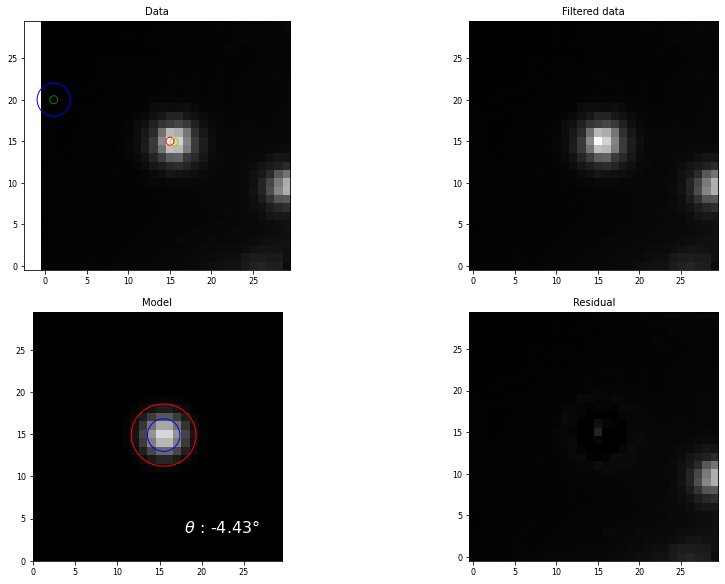

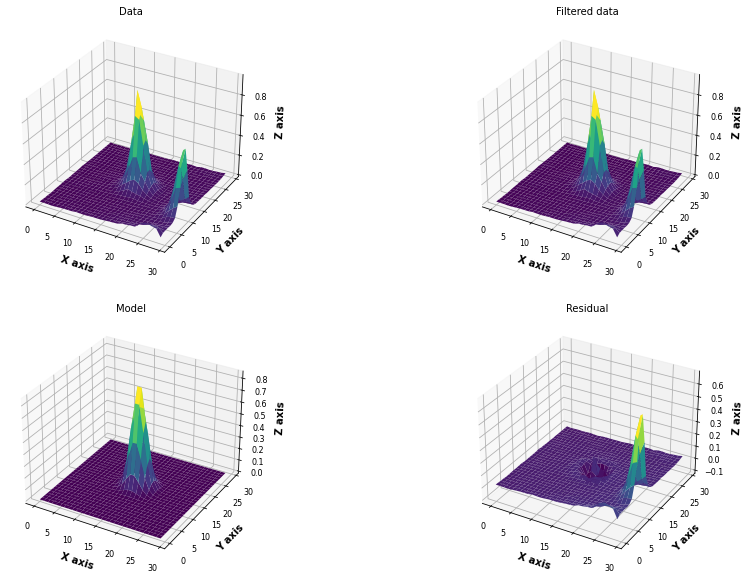

In [22]:
check(851333);

x_mean, y_mean
5811.809515786554 8322.954370884125
A, x0(box), y0(box), x_std, y_std, theta, x0(img), y0(img)
0.8800400542753832 14.809515786553966 14.954370884124375 1.4862490787825073 1.4363812982627644 -0.5327602792845137 29.0 18.0
A_init
1901.9359
fwhmx, fwhmx = (3.4998, 3.3824)
0.8721724004349165 0.8800400542753832
rms = 0.026839013663186324


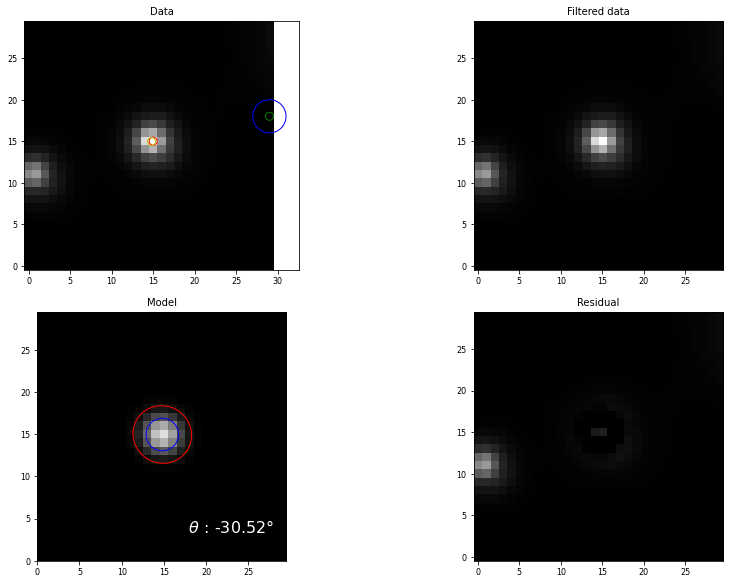

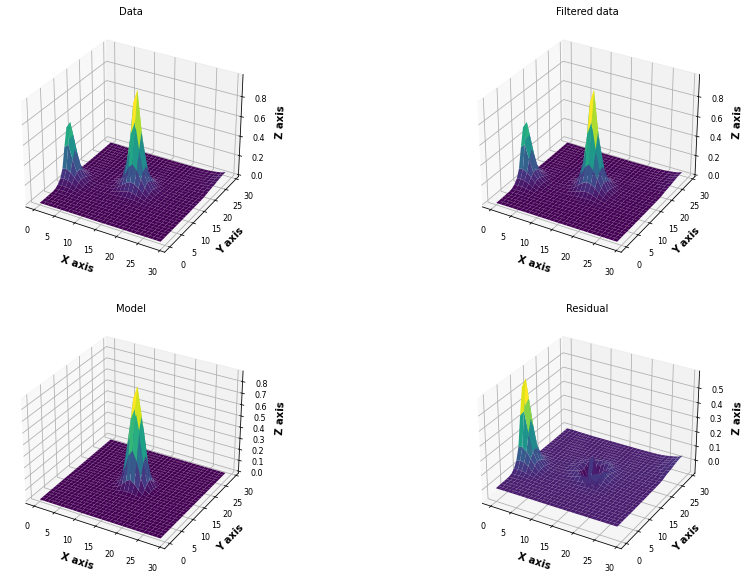

In [23]:
check(702170);

x_mean, y_mean
595.3067205242243 5853.947909447493
A, x0(box), y0(box), x_std, y_std, theta, x0(img), y0(img)
0.33338283036585376 14.328720524224149 26.794909447492763 2.5413991175579733 11.311398488307155 0.006795305245640263 15.0 25.0
A_init
1767.1049
fwhmx, fwhmx = (5.9845, 26.6363)
0.33057363728759553 0.33338283036585376
rms = 0.058460083579677


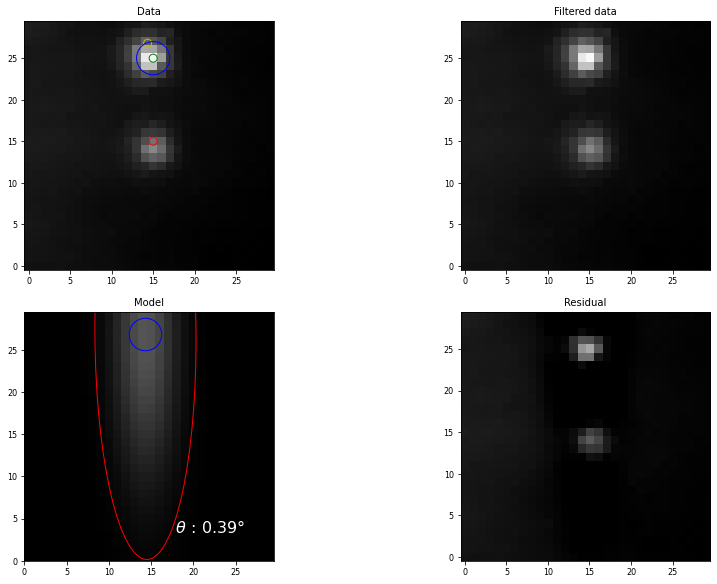

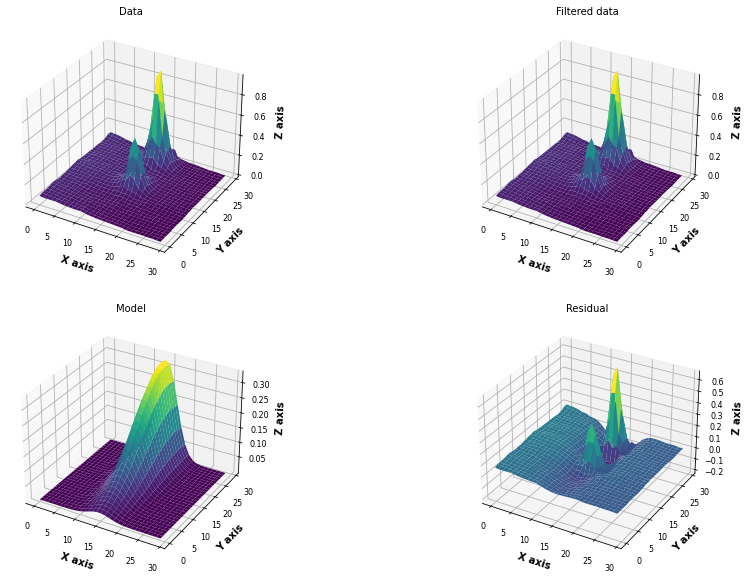

In [24]:
check(484671);

In [25]:
goodness_of_fit(box, fit)

NameError: name 'box' is not defined

In [ ]:
box, fit, _ =check(846974.0);

In [ ]:
check(485924, bb=15);

In [ ]:
cols = ['sigma_x', 'sigma_y', 'theta_mod', 'r_square', 'sharp', 'chi', 'rms']
mask = (results.A != 0) & (results.r_square > 0.9)

plt.figure(figsize=(10,10))
cm = np.corrcoef(results.loc[mask, cols].to_numpy().T)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols,
                 cmap = cmap)
plt.tight_layout();

In [ ]:
# Stars with 7 digits ID represent artificial stars introduced for calibration.
data[data.ID >= 1e6]